<a href="https://colab.research.google.com/github/AshwinRamachandran2002/soc/blob/main/RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import imutils
import time
import cv2

In [ ]:
import imutils
def sliding_window(image, step, ws):
	# slide a window across the image
	for y in range(0, image.shape[0] - ws[1], step):
		for x in range(0, image.shape[1] - ws[0], step):
			# yield the current window
			yield (x, y, image[y:y + ws[1], x:x + ws[0]])


In [ ]:
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
	yield image
	while True:
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break
		yield image

In [ ]:
# initialize variables used for the object detection procedure
WIDTH = 600
PYR_SCALE = 1.5
WIN_STEP = 16
ROI_SIZE = (200, 150)
INPUT_SIZE = (224, 224)

102973440/102967424 [==============================] - 1s 0us/step


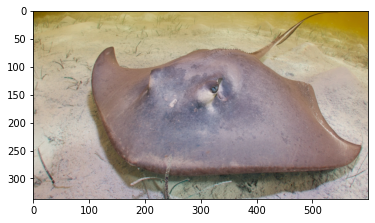

In [ ]:
model = ResNet50(weights="imagenet", include_top=True)
orig = cv2.imread('/content/stingray-ocean-floor.webp')
orig = imutils.resize(orig, width=WIDTH)
(H, W) = orig.shape[:2]
plt.imshow(orig)

In [ ]:
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
rois = []
locs = []

In [ ]:
for image in pyramid:
	scale = W / float(image.shape[1])
	for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
		# scale the (x, y)-coordinates of the ROI with respect to the
		# *original* image dimensions
		x = int(x * scale)
		y = int(y * scale)
		w = int(ROI_SIZE[0] * scale)
		h = int(ROI_SIZE[1] * scale)
		# take the ROI and preprocess it so we can later classify
		# the region using Keras/TensorFlow
		roi = cv2.resize(roiOrig, INPUT_SIZE)
		roi = img_to_array(roi)
		roi = preprocess_input(roi)
		# update our list of ROIs and associated coordinates
		rois.append(roi)
		locs.append((x, y, x + w, y + h))

In [ ]:
rois = np.array(rois, dtype="float32")
preds = model.predict(rois)
preds = imagenet_utils.decode_predictions(preds, top=1)
labels = {}

[INFO] classifying ROIs...
[INFO] classifying ROIs took 34.80058 seconds


In [ ]:
for (i, p) in enumerate(preds):
	# grab the prediction information for the current ROI
	(imagenetID, label, prob) = p[0]
	# filter out weak detections by ensuring the predicted probability
	# is greater than the minimum probability
	if prob >=0.95:
		# grab the bounding box associated with the prediction and
		# convert the coordinates
		box = locs[i]
		# grab the list of predictions for the label and add the
		# bounding box and probability to the list
		L = labels.get(label, [])
		L.append((box, prob))
		labels[label] = L

[INFO] showing results for 'hammerhead'
[INFO] showing results for 'stingray'


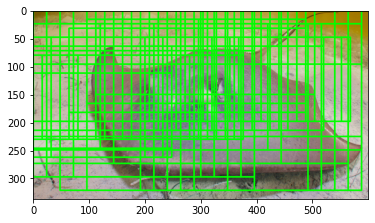

In [ ]:
for label in labels.keys():
	# clone the original image so that we can draw on it
	print("[INFO] showing results for '{}'".format(label))
	clone = orig.copy()
	# loop over all bounding boxes for the current label
	for (box, prob) in labels[label]:
		# draw the bounding box on the image
		(startX, startY, endX, endY) = box
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)
	# show the results *before* applying non-maxima suppression, then
	# clone the image again so we can display the results *after*
	# applying non-maxima suppression
	plt.imshow( clone)
	clone = orig.copy()
 
  # extract the bounding boxes and associated prediction
	# probabilities, then apply non-maxima suppression
	boxes = np.array([p[0] for p in labels[label]])
	proba = np.array([p[1] for p in labels[label]])
	boxes = non_max_suppression(boxes, proba)
	# loop over all bounding boxes that were kept after applying
	# non-maxima suppression
	for (startX, startY, endX, endY) in boxes:
		# draw the bounding box and label on the image
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.putText(clone, label, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
	# show the output after apply non-maxima suppression
	


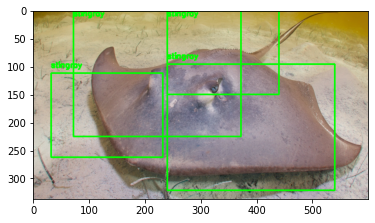

In [ ]:
plt.imshow(clone)

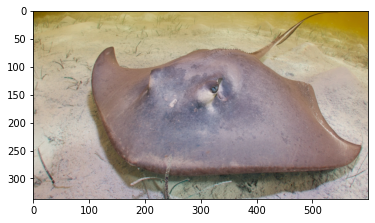

In [ ]:
model = ResNet50(weights="imagenet", include_top=True)
orig = cv2.imread('/content/stingray-ocean-floor.webp')
orig = imutils.resize(orig, width=WIDTH)
(H, W) = orig.shape[:2]
plt.imshow(orig)

In [ ]:
new=cv2.resize(orig,(224,224))

In [ ]:
new.shape

(224, 224, 3)

In [ ]:
new=np.reshape(new,(1,224,224,3))

In [ ]:
preds=model.predict(new)
preds = imagenet_utils.decode_predictions(preds, top=1)

40960/35363 [==================================] - 0s 0us/step


In [ ]:
print(preds)

[[('n01498041', 'stingray', 0.9935935)]]


In [ ]:
# load the input image
image = cv2.imread('/content/stingray-ocean-floor.webp')
# initialize OpenCV's selective search implementation and set the
# input image
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchQuality()
rects = ss.process()

KeyboardInterrupt: ignored

In [ ]:
for i in range(0, len(rects), 100):
	# clone the original image so we can draw on it
	output = image.copy()
	# loop over the current subset of region proposals
	for (x, y, w, h) in rects[i:i + 100]:
		# draw the region proposal bounding box on the image
		color = [random.randint(0, 255) for j in range(0, 3)]
		cv2.rectangle(output, (x, y), (x + w, y + h), color, 2)
	# show the output image
	plt.imshow(output)
	key = cv2.waitKey(0) & 0xFF
	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break